In [1]:
SOURCE = '../data/caterpillar/caterpillar-tube-pricing/competition_data/'

In [2]:
import pandas as pd
materials = pd.read_csv(SOURCE + 'bill_of_materials.csv')
materials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


| Crosstab | C-1622 | C-1629 | C-1312 | C-1624 | C-1631 | C-1641 | Distinct | Total |
|:--------:|:------:|--------|--------|--------|--------|--------|----------|-------|
| TA-00001 | 2      | 2      | 0      | 0      | 0      | 0      | 2        | 4     |
| TA-00002 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00003 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00004 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00005 | 0      | 0      | 0      | 1      | 1      | 1      | 3        | 3     |

In [3]:
components = pd.read_csv(SOURCE + 'components.csv')
components.describe()

,component_id,name,component_type_id
count,2048,2047,2048
unique,2048,297,29
top,C-1641,FLANGE,OTHER
freq,1,350,1006


In [4]:
components.head()

,component_id,name,component_type_id
0,9999,OTHER,OTHER
1,C-0001,SLEEVE,CP-024
2,C-0002,SLEEVE,CP-024
3,C-0003,SLEEVE-FLARED,CP-024
4,C-0004,NUT,CP-026


In [5]:
import category_encoders as ce
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge tube data
    tube = pd.read_csv(SOURCE + 'tube.csv')
    X = X.merge(tube, how='left')
    
    # Engineer features from bill_of_materials
    materials = pd.read_csv(SOURCE + 'bill_of_materials.csv')
    
    materials['components_total'] = (materials['quantity_1'].fillna(0) + 
                                     materials['quantity_2'].fillna(0) + 
                                     materials['quantity_3'].fillna(0) + 
                                     materials['quantity_4'].fillna(0) + 
                                     materials['quantity_5'].fillna(0) + 
                                     materials['quantity_6'].fillna(0) + 
                                     materials['quantity_7'].fillna(0) + 
                                     materials['quantity_8'].fillna(0))

    materials['components_distinct'] = (materials['component_id_1'].notnull().astype(int) + 
                                        materials['component_id_2'].notnull().astype(int) + 
                                        materials['component_id_3'].notnull().astype(int) + 
                                        materials['component_id_4'].notnull().astype(int) + 
                                        materials['component_id_5'].notnull().astype(int) + 
                                        materials['component_id_6'].notnull().astype(int) + 
                                        materials['component_id_7'].notnull().astype(int) + 
                                        materials['component_id_8'].notnull().astype(int))
    
    # Merge selected features from bill_of_materials
    # Just use the first component_id, ignore the others for now!
    features = ['tube_assembly_id', 'component_id_1', 'components_total', 'components_distinct']
    X = X.merge(materials[features], how='left')
    
    # Get component_type_id (has lower cardinality than component_id)
    components = pd.read_csv(SOURCE + 'components.csv')
    components = components.rename(columns={'component_id': 'component_id_1'})
    features = ['component_id_1', 'component_type_id']
    X = X.merge(components[features], how='left')
    
    # Count the number of specs for the tube assembly
    specs = pd.read_csv(SOURCE + 'specs.csv')
    specs['specs_total'] = specs.drop(columns=['tube_assembly_id']).count(axis=1)
    features = ['tube_assembly_id', 'specs_total', 'spec1']
    X = X.merge(specs[features], how='left')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    return X


# Read data
trainval = pd.read_csv(SOURCE + 'train_set.csv')
test = pd.read_csv(SOURCE + 'test_set.csv')

# Split into train & validation sets
# All rows for a given tube_assembly_id should go in either train or validation
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

# Wrangle train, validation, and test sets
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange X matrix and y vector (log-transformed)
target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [6]:
# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

# Predict
def generate_submission(estimator, X_test, filename):
    y_pred_log = estimator.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
    submission = pd.read_csv(SOURCE + '../sample_submission.csv')
    submission['cost'] = y_pred
    submission.to_csv(filename, index=False)
    
generate_submission(pipeline, X_test, 'submission-03.csv')

Validation Error 0.29689405271419284


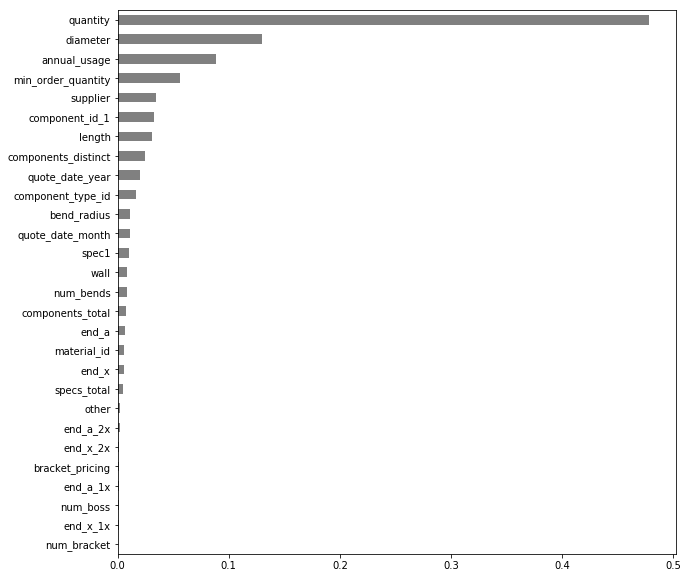

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

## Use xgboost for gradient boosting

#### [XGBoost Python API Reference: Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [12]:
from xgboost import XGBRegressor

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=1000, n_job=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:35:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error 0.2700581596577784


In [13]:
generate_submission(pipeline, X_test, 'submission_xgboost_1.csv')

In [14]:
import category_encoders as ce

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [15]:
eval_set = [
    (X_train_encoded, y_train_log),
    (X_val_encoded, y_val_log)
]

In [16]:
import xgboost
model = XGBRegressor(n_estimators=1000, n_job=-1)

model.fit(X_train_encoded, 
          y_train_log, 
          eval_set=eval_set,
          eval_metric='rmse',
          early_stopping_rounds=10
         )

[21:36:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.71924	validation_1-rmse:1.70846
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.56516	validation_1-rmse:1.55498
[2]	validation_0-rmse:1.42779	validation_1-rmse:1.41846


/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[3]	validation_0-rmse:1.30338	validation_1-rmse:1.29429
[4]	validation_0-rmse:1.19168	validation_1-rmse:1.18295
[5]	validation_0-rmse:1.09322	validation_1-rmse:1.08553
[6]	validation_0-rmse:1.0052	validation_1-rmse:0.997831
[7]	validation_0-rmse:0.927625	validation_1-rmse:0.922044
[8]	validation_0-rmse:0.859914	validation_1-rmse:0.85702
[9]	validation_0-rmse:0.799929	validation_1-rmse:0.798434
[10]	validation_0-rmse:0.747475	validation_1-rmse:0.747741
[11]	validation_0-rmse:0.700331	validation_1-rmse:0.700593
[12]	validation_0-rmse:0.660556	validation_1-rmse:0.662626
[13]	validation_0-rmse:0.62315	validation_1-rmse:0.625613
[14]	validation_0-rmse:0.592344	validation_1-rmse:0.5964
[15]	validation_0-rmse:0.563782	validation_1-rmse:0.568364
[16]	validation_0-rmse:0.540558	validation_1-rmse:0.546318
[17]	validation_0-rmse:0.519686	validation_1-rmse:0.5262
[18]	validation_0-rmse:0.501662	validation_1-rmse:0.509163
[19]	validation_0-rmse:0.483726	validation_1-rmse:0.492812
[20]	validation_0-

[143]	validation_0-rmse:0.289504	validation_1-rmse:0.319006
[144]	validation_0-rmse:0.28927	validation_1-rmse:0.318959
[145]	validation_0-rmse:0.289149	validation_1-rmse:0.318867
[146]	validation_0-rmse:0.288531	validation_1-rmse:0.318088
[147]	validation_0-rmse:0.288218	validation_1-rmse:0.317771
[148]	validation_0-rmse:0.288105	validation_1-rmse:0.317679
[149]	validation_0-rmse:0.287501	validation_1-rmse:0.317112
[150]	validation_0-rmse:0.287182	validation_1-rmse:0.316784
[151]	validation_0-rmse:0.286461	validation_1-rmse:0.316538
[152]	validation_0-rmse:0.28613	validation_1-rmse:0.316384
[153]	validation_0-rmse:0.286008	validation_1-rmse:0.316327
[154]	validation_0-rmse:0.285845	validation_1-rmse:0.316294
[155]	validation_0-rmse:0.28535	validation_1-rmse:0.315859
[156]	validation_0-rmse:0.284829	validation_1-rmse:0.315371
[157]	validation_0-rmse:0.284417	validation_1-rmse:0.315119
[158]	validation_0-rmse:0.284118	validation_1-rmse:0.314943
[159]	validation_0-rmse:0.284032	validation

[281]	validation_0-rmse:0.256219	validation_1-rmse:0.296277
[282]	validation_0-rmse:0.256132	validation_1-rmse:0.296184
[283]	validation_0-rmse:0.256076	validation_1-rmse:0.296163
[284]	validation_0-rmse:0.255978	validation_1-rmse:0.296221
[285]	validation_0-rmse:0.255853	validation_1-rmse:0.296097
[286]	validation_0-rmse:0.255583	validation_1-rmse:0.295978
[287]	validation_0-rmse:0.255388	validation_1-rmse:0.295725
[288]	validation_0-rmse:0.255235	validation_1-rmse:0.295605
[289]	validation_0-rmse:0.255167	validation_1-rmse:0.295544
[290]	validation_0-rmse:0.255083	validation_1-rmse:0.295558
[291]	validation_0-rmse:0.254841	validation_1-rmse:0.295394
[292]	validation_0-rmse:0.254599	validation_1-rmse:0.295295
[293]	validation_0-rmse:0.25445	validation_1-rmse:0.295233
[294]	validation_0-rmse:0.254323	validation_1-rmse:0.295215
[295]	validation_0-rmse:0.254256	validation_1-rmse:0.295223
[296]	validation_0-rmse:0.254213	validation_1-rmse:0.295232
[297]	validation_0-rmse:0.253983	validati

[419]	validation_0-rmse:0.237546	validation_1-rmse:0.284644
[420]	validation_0-rmse:0.237506	validation_1-rmse:0.284541
[421]	validation_0-rmse:0.237427	validation_1-rmse:0.284535
[422]	validation_0-rmse:0.237308	validation_1-rmse:0.284584
[423]	validation_0-rmse:0.237182	validation_1-rmse:0.284557
[424]	validation_0-rmse:0.237119	validation_1-rmse:0.284635
[425]	validation_0-rmse:0.237017	validation_1-rmse:0.28438
[426]	validation_0-rmse:0.236972	validation_1-rmse:0.284378
[427]	validation_0-rmse:0.236869	validation_1-rmse:0.284241
[428]	validation_0-rmse:0.236785	validation_1-rmse:0.284249
[429]	validation_0-rmse:0.236689	validation_1-rmse:0.284101
[430]	validation_0-rmse:0.236599	validation_1-rmse:0.284094
[431]	validation_0-rmse:0.236474	validation_1-rmse:0.284047
[432]	validation_0-rmse:0.236363	validation_1-rmse:0.284029
[433]	validation_0-rmse:0.236291	validation_1-rmse:0.28404
[434]	validation_0-rmse:0.236198	validation_1-rmse:0.284042
[435]	validation_0-rmse:0.236095	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_job=-1, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

(0.2, 0.4)

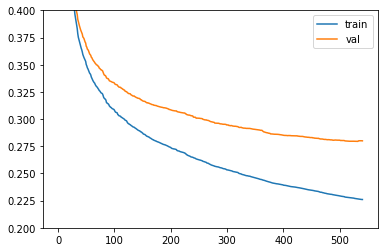

In [17]:
results = model.evals_result()

train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']

epochs = range(0, len(train_rmse))

plt.plot(epochs, train_rmse, label='train')
plt.plot(epochs, val_rmse, label='val')
plt.legend();
plt.ylim(0.2, 0.4)

In [19]:
from catboost import CatBoostRegressor

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    CatBoostRegressor(learning_rate=0.3)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

0:	learn: 1.7063512	total: 73.6ms	remaining: 1m 13s
1:	learn: 1.2756902	total: 84.7ms	remaining: 42.3s
2:	learn: 0.9694022	total: 96.9ms	remaining: 32.2s
3:	learn: 0.7520570	total: 109ms	remaining: 27.1s
4:	learn: 0.6097303	total: 121ms	remaining: 24.1s
5:	learn: 0.5294796	total: 133ms	remaining: 22.1s
6:	learn: 0.4657627	total: 144ms	remaining: 20.5s
7:	learn: 0.4252448	total: 159ms	remaining: 19.7s
8:	learn: 0.3983808	total: 172ms	remaining: 18.9s
9:	learn: 0.3842124	total: 183ms	remaining: 18.2s
10:	learn: 0.3694200	total: 197ms	remaining: 17.7s
11:	learn: 0.3633047	total: 208ms	remaining: 17.1s
12:	learn: 0.3547063	total: 221ms	remaining: 16.8s
13:	learn: 0.3488532	total: 233ms	remaining: 16.4s
14:	learn: 0.3437360	total: 245ms	remaining: 16.1s
15:	learn: 0.3423312	total: 256ms	remaining: 15.8s
16:	learn: 0.3399380	total: 269ms	remaining: 15.6s
17:	learn: 0.3372858	total: 300ms	remaining: 16.4s
18:	learn: 0.3322560	total: 314ms	remaining: 16.2s
19:	learn: 0.3303295	total: 325ms	rem

172:	learn: 0.2366601	total: 2.38s	remaining: 11.4s
173:	learn: 0.2366303	total: 2.39s	remaining: 11.3s
174:	learn: 0.2365849	total: 2.4s	remaining: 11.3s
175:	learn: 0.2361720	total: 2.41s	remaining: 11.3s
176:	learn: 0.2356582	total: 2.43s	remaining: 11.3s
177:	learn: 0.2356543	total: 2.44s	remaining: 11.3s
178:	learn: 0.2356503	total: 2.45s	remaining: 11.2s
179:	learn: 0.2356497	total: 2.46s	remaining: 11.2s
180:	learn: 0.2356492	total: 2.47s	remaining: 11.2s
181:	learn: 0.2356471	total: 2.48s	remaining: 11.2s
182:	learn: 0.2356453	total: 2.49s	remaining: 11.1s
183:	learn: 0.2356434	total: 2.5s	remaining: 11.1s
184:	learn: 0.2356415	total: 2.52s	remaining: 11.1s
185:	learn: 0.2356403	total: 2.53s	remaining: 11.1s
186:	learn: 0.2355860	total: 2.54s	remaining: 11s
187:	learn: 0.2354811	total: 2.55s	remaining: 11s
188:	learn: 0.2353933	total: 2.56s	remaining: 11s
189:	learn: 0.2353783	total: 2.59s	remaining: 11s
190:	learn: 0.2350144	total: 2.6s	remaining: 11s
191:	learn: 0.2348306	tot

342:	learn: 0.2209088	total: 4.67s	remaining: 8.95s
343:	learn: 0.2209014	total: 4.68s	remaining: 8.93s
344:	learn: 0.2209012	total: 4.7s	remaining: 8.91s
345:	learn: 0.2209010	total: 4.71s	remaining: 8.9s
346:	learn: 0.2209010	total: 4.71s	remaining: 8.87s
347:	learn: 0.2209009	total: 4.72s	remaining: 8.85s
348:	learn: 0.2208844	total: 4.73s	remaining: 8.83s
349:	learn: 0.2208843	total: 4.74s	remaining: 8.81s
350:	learn: 0.2208841	total: 4.75s	remaining: 8.79s
351:	learn: 0.2208840	total: 4.76s	remaining: 8.77s
352:	learn: 0.2208834	total: 4.77s	remaining: 8.75s
353:	learn: 0.2208833	total: 4.78s	remaining: 8.73s
354:	learn: 0.2208687	total: 4.79s	remaining: 8.71s
355:	learn: 0.2208685	total: 4.81s	remaining: 8.7s
356:	learn: 0.2208672	total: 4.82s	remaining: 8.68s
357:	learn: 0.2208671	total: 4.83s	remaining: 8.66s
358:	learn: 0.2208670	total: 4.84s	remaining: 8.64s
359:	learn: 0.2208389	total: 4.85s	remaining: 8.62s
360:	learn: 0.2208385	total: 4.86s	remaining: 8.61s
361:	learn: 0.2

508:	learn: 0.2092613	total: 6.99s	remaining: 6.74s
509:	learn: 0.2086848	total: 7.01s	remaining: 6.74s
510:	learn: 0.2086723	total: 7.04s	remaining: 6.74s
511:	learn: 0.2086667	total: 7.07s	remaining: 6.74s
512:	learn: 0.2086662	total: 7.09s	remaining: 6.73s
513:	learn: 0.2086638	total: 7.11s	remaining: 6.72s
514:	learn: 0.2086590	total: 7.13s	remaining: 6.71s
515:	learn: 0.2086584	total: 7.15s	remaining: 6.71s
516:	learn: 0.2082166	total: 7.17s	remaining: 6.7s
517:	learn: 0.2082126	total: 7.21s	remaining: 6.71s
518:	learn: 0.2081978	total: 7.25s	remaining: 6.71s
519:	learn: 0.2081977	total: 7.26s	remaining: 6.7s
520:	learn: 0.2081526	total: 7.28s	remaining: 6.69s
521:	learn: 0.2081401	total: 7.3s	remaining: 6.68s
522:	learn: 0.2081326	total: 7.32s	remaining: 6.67s
523:	learn: 0.2081322	total: 7.34s	remaining: 6.67s
524:	learn: 0.2081321	total: 7.35s	remaining: 6.65s
525:	learn: 0.2081313	total: 7.38s	remaining: 6.65s
526:	learn: 0.2081309	total: 7.43s	remaining: 6.67s
527:	learn: 0.2

679:	learn: 0.2027066	total: 9.47s	remaining: 4.46s
680:	learn: 0.2027010	total: 9.48s	remaining: 4.44s
681:	learn: 0.2027006	total: 9.49s	remaining: 4.42s
682:	learn: 0.2027005	total: 9.5s	remaining: 4.41s
683:	learn: 0.2026957	total: 9.51s	remaining: 4.39s
684:	learn: 0.2026559	total: 9.52s	remaining: 4.38s
685:	learn: 0.2026559	total: 9.54s	remaining: 4.37s
686:	learn: 0.2026509	total: 9.55s	remaining: 4.35s
687:	learn: 0.2026507	total: 9.56s	remaining: 4.34s
688:	learn: 0.2023524	total: 9.57s	remaining: 4.32s
689:	learn: 0.2023507	total: 9.58s	remaining: 4.3s
690:	learn: 0.2022696	total: 9.6s	remaining: 4.29s
691:	learn: 0.2022675	total: 9.61s	remaining: 4.28s
692:	learn: 0.2022671	total: 9.62s	remaining: 4.26s
693:	learn: 0.2022669	total: 9.63s	remaining: 4.25s
694:	learn: 0.2022667	total: 9.64s	remaining: 4.23s
695:	learn: 0.2022666	total: 9.67s	remaining: 4.22s
696:	learn: 0.2022655	total: 9.69s	remaining: 4.21s
697:	learn: 0.2022655	total: 9.7s	remaining: 4.2s
698:	learn: 0.202

847:	learn: 0.1987070	total: 12.3s	remaining: 2.2s
848:	learn: 0.1987069	total: 12.3s	remaining: 2.19s
849:	learn: 0.1987067	total: 12.3s	remaining: 2.17s
850:	learn: 0.1987037	total: 12.3s	remaining: 2.16s
851:	learn: 0.1987035	total: 12.3s	remaining: 2.14s
852:	learn: 0.1987028	total: 12.3s	remaining: 2.13s
853:	learn: 0.1987013	total: 12.4s	remaining: 2.11s
854:	learn: 0.1987012	total: 12.4s	remaining: 2.1s
855:	learn: 0.1986980	total: 12.4s	remaining: 2.08s
856:	learn: 0.1986968	total: 12.4s	remaining: 2.07s
857:	learn: 0.1986868	total: 12.4s	remaining: 2.05s
858:	learn: 0.1986850	total: 12.4s	remaining: 2.04s
859:	learn: 0.1986849	total: 12.4s	remaining: 2.02s
860:	learn: 0.1986849	total: 12.4s	remaining: 2.01s
861:	learn: 0.1986847	total: 12.4s	remaining: 1.99s
862:	learn: 0.1986846	total: 12.5s	remaining: 1.98s
863:	learn: 0.1983071	total: 12.5s	remaining: 1.96s
864:	learn: 0.1983046	total: 12.5s	remaining: 1.95s
865:	learn: 0.1983022	total: 12.5s	remaining: 1.94s
866:	learn: 0.

In [24]:
import lightgbm as lgbm

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    lgbm.sklearn.LGBMRegressor(learning_rate=0.2)
)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

OSError: dlopen(/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

#### Kaggle RMSLE: 0.29454